## LEARNING MACHINE LEARNING 2018

# Lab 8: Convolutional Neural Networks (CNNs)

**Universidad del Rosario**<br>
**July 26, 2018**<br>
**Instructors: Pavlos Protopapas, Rafael Martinez, Juan Fernando Perez, Dora Suarez, Juan Felipe Giraldo, Dora Suarez, Julian Rincon, German Obando**

Some of the text and material for this lab comes from:
https://xrds.acm.org/blog/2016/06/convolutional-neural-networks-cnns-illustrated-explanation/
https://www.kaggle.com/ernie55ernie/mnist-with-keras-visualization-and-saliency-map/notebook

### Generalities

Often in machine learning applications involving images (such as image classification, automatic image captioning, object dection, recognition or scene labeling) the first task is to parse an image into a set of 'features' that are relevant for the task at hand. That is, we prefer not to work with images as a set of pixels. **Question:** can you think of some reasons for why this is? Traditionally, the set of relevant features to extract from raw images need to be defined before hand using domain expertise and then must be 'engineered' (computed) from the images represented as pixels. For example, for training a model to distinguish a night scene from a day scene, one might want to compare the color histograms of two images. The problem with the approach of feature engineering is that, a priori, it can be difficult to know what type of features best facilitate the performance of a given task, furthermore, the features one has engineered to optimize one task may not generalize to help accomplish another.

Neural networks provide a natural and flexible framework for extracting useful features from raw images. Often, while training a NN to accomplish a particular task (like classification) we get, from this process, a useful alternate representaiton of the data. Taking this intuition further, we ask whether or not we can use a neural network to automatically extract useful features (or alternate representations) from the data by optimizing the network for a particular task.

In this lab, we will consider a particular type of neural network, the convolutional network (CNN), that is especially suited for feature extraction of image data. A CNN is a neural network typically composed of two components, one component for extracting useful features of the data, and another for performing a ML task (like classification based on the featurized data:

<img src="cnn.png" style="width: 700px;" align="center"/>

The feature extracting layers are called **convolutional layers**, each node in these layers uses a small fixed set of weights to transform the image in the following way:

<img src="convolution_layer.gif" style="width: 600px;" align="center"/>

This set of fixed weights for each node in the convolutional layer is often called a ***filter*** or a ***kernel***. The term "filter" comes from image processing where one has standard ways to transforms raw images:

<img src="filter_apply.gif" style="width: 600px;" align="center"/>

In [1]:
%matplotlib inline
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import matplotlib.pyplot as plt
import seaborn as sns

#from subprocess import check_output

/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Preparing the dataset

The first thing we do is to load our dataset. Once again, we will do this exercise with the MNIST dataset of handwritten digits. Keras allows us to load it already split in training and testing sets, but we will do to things differently now: We will use only a small fraction (10%) of the entire dataset to save computational costs during training:

In [2]:
from keras.datasets import mnist

(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

# Shuffle training and test set
s = np.arange(Y_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
Y_test = Y_test[s]

p = np.arange(Y_train.shape[0])
np.random.shuffle(p)
X_train = X_train[p]
Y_train = Y_train[p]

X_train = X_train[0:6000]
Y_train = Y_train[0:6000]
#X_valid = X_test[0:500]
#Y_valid = Y_test[0:500]
X_test = X_test[500:1000]
Y_test = Y_test[500:1000]

Using TensorFlow backend.


We now reshape the sets so that they have the right shape to be understood by the CNN. This is different from what we did in the fully connected example of Lab 4. This is because the CNN does care about spatial information, since nuerons in the first convolutional layer are responsive only to certain features in the input field.

In [3]:
X_train = X_train.reshape(len(X_train), 28, 28, 1)
X_test = X_test.reshape(len(X_test), 28, 28, 1)

Next, we rescale the image data so that each pixel lies in the interval [0, 1] instead of the default [0, 255]. (In general, it’s a good idea to standarize the data for your problem so that each dimension has approximately the same scale.). We also check if the classes are distribute uniformly.

There are 6000 training data and 500 testing data.
Number of occurence for each number in training data (0 stands for 10):
[[  0 570]
 [  1 668]
 [  2 622]
 [  3 609]
 [  4 576]
 [  5 560]
 [  6 603]
 [  7 623]
 [  8 572]
 [  9 597]]


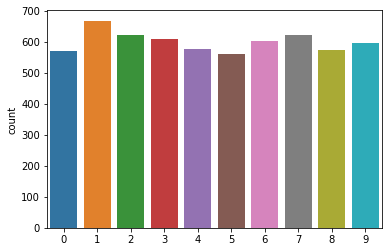

In [4]:
# normalization
X_train = np.array(X_train) / 255.
Y_train = np.array(Y_train)
X_test = np.array(X_test) / 255.
Y_test = np.array(Y_test)
#X_valid = np.array(X_valid) / 255.
#Y_valid = np.array(Y_valid)

print('There are', X_train.shape[0], 'training data and',  X_test.shape[0], 'testing data.')
print('Number of occurence for each number in training data (0 stands for 10):')
print(np.vstack((np.unique(Y_train), np.bincount(Y_train))).T)
sns.countplot(Y_train)

Next, we plot a bunch of examples from the training set, just to get a feeling of how the digits look like.

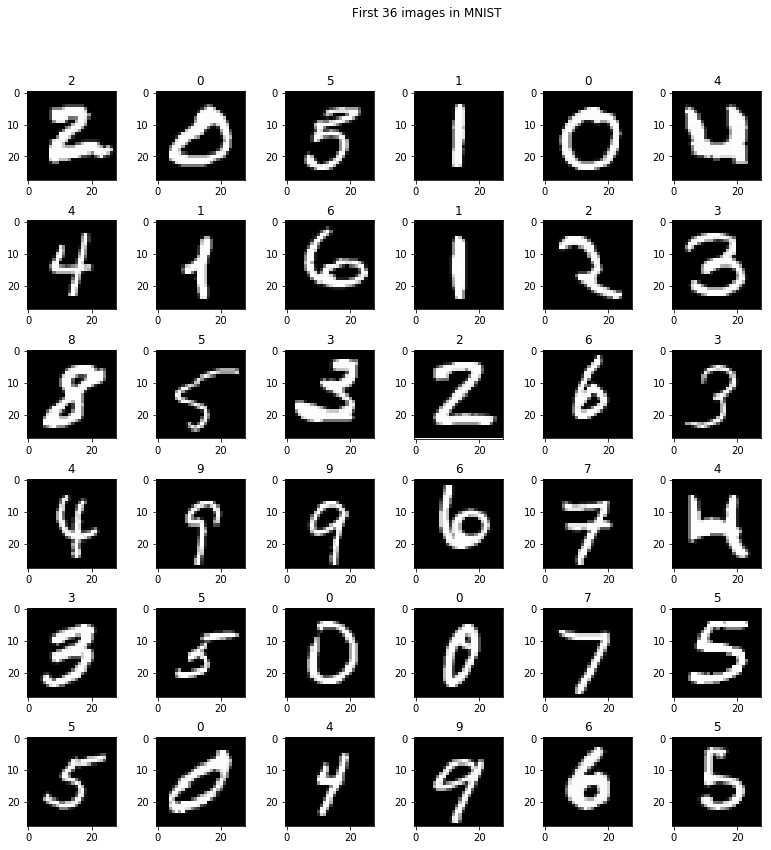

In [5]:
# plot first 36 images in MNIST
fig, ax = plt.subplots(6, 6, figsize = (12, 12))
fig.suptitle('First 36 images in MNIST')
fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
for x, y in [(i, j) for i in range(6) for j in range(6)]:
    ax[x, y].imshow(X_train[x + y * 6].reshape((28, 28)), cmap = 'gray')
    ax[x, y].set_title(Y_train[x + y * 6])

Just like we did in Lab 4, we convert our training and testing labels into categorical binary arrays that replace the actual digits for a single bit in the right position.

In [6]:
from keras.utils import to_categorical

Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

Let us now print the shape of our training test. Notice that the first dimension is the number of examples in the training set, the second and third are the dimensions of each image, and the third is the number of 'colors' in which the images are available. In this case we only have one color, so the dimension is one

In [7]:
print(np.shape(X_train))

(6000, 28, 28, 1)


### Building the CNN model

Now comes the most important part, where we build our CNN model. In the following implementation we have two convolutional layers, each of which uses a Rectifier Linear Unit (ReLU) activation. We also perform Max Pooling after each convolutional layer, and finally add two dense layers. We also use two dropout layers. 

Note that in the last part below, when we compile the model, we select the categorical cross-entropy as loss function (we are doing classification with more than two classes), and also use the `rmsprop` optimizer. This optimizer is similar to Stochastic Gradiend Descent, but you divide the learning rate for a weight by a running average of the magnitudes of recent gradients for that weight. This makes the optimization more efficient

After the next code cell, we explain what each of this layers does.

In [8]:
# Import needed models and layers
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator

img_size = (28,28,1) # Dimensions of the input volume
n_classes = 10       # Number of classes

model = Sequential()
model.add(Conv2D(32, (5, 5), input_shape = img_size, kernel_initializer = 'normal'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Conv2D(64, (5, 5), kernel_initializer = 'normal'))
model.add(Activation('relu'))
#model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.1))

model.add(Flatten())
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dense(n_classes))
model.add(Activation('softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics = ['accuracy'])


*The Convolutional Layer*

There is always a convolutional layer right after the input volume layer. Each of these layers has a number of filters or convolutional kernels (the number of filters is specified as the first argument in `Conv2D`, and its also know as the depth of the layer). The input image is convolved with each of these filters using a given stride (i.e., by how many positions the kernel moves in the input data before operating again). An activation function is added, usually a ReLu activation. The resulting output is called the activation map for that particular filter.

*Pooling*

This layer reduces the spatial dimensions (Width x Height) of the input volume for the next convolutional layer. It does not affect the depth dimension of the volume. The operation performed by this layer is also called ‘down-sampling’, as the reduction of size leads to loss of information as well. However, such a loss is beneficial for the network for two reasons:

* the decrease in size leads to less computational overhead for the upcoming layers of the network;
* it work against over-fitting.

The transformation is either performed by taking the maximum value from the values observable in the window (called ‘max pooling’), or by taking the average of the values.

*Dropout*

Dropout is a regularization technique for neural network models proposed by Srivastava, et al. in their 2014 paper Dropout: A Simple Way to Prevent Neural Networks from Overfitting. Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass. 

*Fully connected*

The Fully Connected layer is configured exactly the way its name implies: it is fully connected with the output of the previous layer. Fully-connected layers are typically used in the last stages of the CNN to connect to the output layer and construct the desired number of outputs, just like we did in the regular CNN. 

In [9]:
print(np.shape(Y_train))

(6000, 10)


We now fit the model. We will use a batch size of 128 (so, 128 examples from the training set are used at each optimization step), will train for 10 epochs, and will select 20% of the training examples for validation at each validation. At each epoch, the training set will be randomly shuffled. In combination with the batch strategy, this will prevent us from getting stuck in a local minima of the loss function, as the training is never performed exactly on the same dataset at each epoch. We let the fitting routine print the progress.

In [10]:
history = model.fit(X_train, Y_train, batch_size = 128, epochs = 10, 
          validation_split = 0.2, verbose = 1)

Train on 4800 samples, validate on 1200 samples
Epoch 1/10
4800/4800 [==============================] - 5s 1ms/step - loss: 0.8753 - acc: 0.7202 - val_loss: 0.5603 - val_acc: 0.8083
Epoch 2/10
4800/4800 [==============================] - 5s 1ms/step - loss: 0.2775 - acc: 0.9129 - val_loss: 0.2526 - val_acc: 0.9200
Epoch 3/10
4800/4800 [==============================] - 4s 883us/step - loss: 0.1756 - acc: 0.9483 - val_loss: 0.1729 - val_acc: 0.9517
Epoch 4/10
4800/4800 [==============================] - 4s 862us/step - loss: 0.1173 - acc: 0.9631 - val_loss: 0.1821 - val_acc: 0.9475
Epoch 5/10
4800/4800 [==============================] - 4s 865us/step - loss: 0.0865 - acc: 0.9704 - val_loss: 0.1979 - val_acc: 0.9433
Epoch 6/10
4800/4800 [==============================] - 5s 966us/step - loss: 0.0666 - acc: 0.9808 - val_loss: 0.1762 - val_acc: 0.9483
Epoch 7/10
4800/4800 [==============================] - 5s 958us/step - loss: 0.0491 - acc: 0.9856 - val_loss: 0.1636 - val_acc: 0.9492
Epoc

As we train the model, we stop after each epoch to check on the validation loss, and see how it is behaving. In general, after an initial adjustment stage, the validation error should be higher than the training (since we should be doing better at classifying the data that we have seen during training).

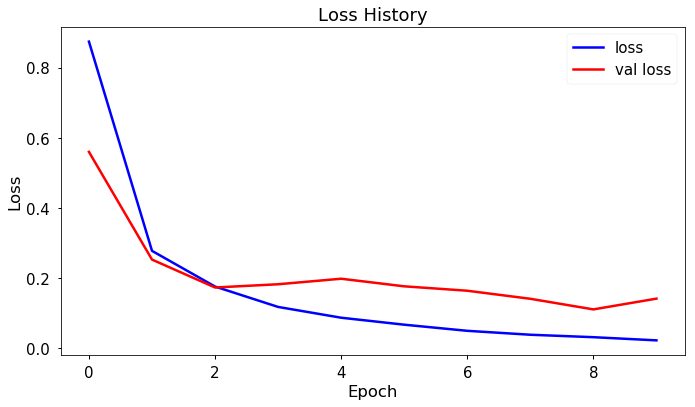

In [11]:
# ------------------------------------------------------------------------------
# Plot: Loss History during Training and Receiver-Operator Curve (ROC)
# ------------------------------------------------------------------------------

try:
    sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
except: 
    pass
hist = history.history
loss = hist['loss']
val_loss = hist['val_loss']
epochs = np.arange(10)
fig, axis1 = plt.subplots(figsize=(10,6))
plt.plot(epochs, loss, 'b', label='loss')
plt.plot(epochs, val_loss, 'r', label="val loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss History")
plt.legend(loc='upper right')
plt.tight_layout()


When do we stop training? Well, we want to make sure that we do not overfit, so we want to keep an eye on the validation error, and see if it starts rising again, since this would be an indication that the model is not good anymore at generalizing, and so it is not performing well in data that has not seem before (it makes many mistakes). This is known as *early stopping*.

Next, once we have trained long enough for the accuracy to be good, without going to far as to overfir, we test the accuracy on the test set:

In [12]:
# Testing
score, acc = model.evaluate(X_test, Y_test, verbose = 1)
print(score)
print(acc)

500/500 [==============================] - 0s 405us/step
0.08943798160552978
0.9779999995231629


In [13]:
print (Y_test)

[[0. 0. 0. ... 1. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


The next thing is to predict the labels for the test set, and visualize the mistakes we make by creating a confusion matrix. We predict by using the attribute `predict` of our model object:

In [14]:
Y_pred = model.predict(X_test)
Y_pred

array([[1.73986216e-12, 2.89299207e-09, 9.79414949e-09, ...,
        1.00000000e+00, 7.97913124e-12, 5.00178245e-08],
       [9.05247405e-11, 9.99998808e-01, 1.33005486e-07, ...,
        9.17229499e-07, 2.94881272e-11, 4.50768178e-09],
       [3.16345177e-06, 5.54542119e-08, 7.78635498e-04, ...,
        1.00158526e-04, 2.13026503e-08, 4.05763945e-04],
       ...,
       [3.60849767e-10, 3.73972808e-09, 1.54486091e-09, ...,
        5.19686921e-07, 9.52533981e-08, 9.99963760e-01],
       [5.88730367e-12, 2.55159366e-11, 3.58205340e-11, ...,
        1.00000000e+00, 1.52829599e-13, 1.45278845e-09],
       [7.08506387e-13, 3.27513419e-07, 3.96486710e-09, ...,
        3.78474391e-10, 4.11696843e-10, 4.62860925e-07]], dtype=float32)

Note that the prediction is just the probability of each of the test examples belonging to the different classes. So we need to turn this back into categorical values by maximizing these probabilities. Let's print these predictions and compare with the true labels. Can you spot the errors?

In [15]:
Y_pred = model.predict(X_test)
Y_pred_real = []
Y_test_real = []
Y_prob = []
for i in range(len(Y_pred)):
    Y_pred_real.append(np.argmax(Y_pred[i], axis=None, out=None))
    Y_test_real.append(np.argmax(Y_test[i], axis=None, out=None))
    Y_prob.append(np.max(Y_pred[i]))
print(Y_pred_real)
print(Y_test_real)

[7, 1, 6, 2, 3, 0, 6, 9, 2, 7, 4, 2, 7, 0, 1, 9, 2, 5, 7, 3, 9, 7, 2, 7, 9, 9, 9, 4, 3, 6, 7, 1, 8, 1, 5, 3, 4, 3, 1, 3, 4, 3, 4, 2, 2, 0, 5, 8, 7, 9, 2, 3, 0, 4, 1, 9, 2, 7, 8, 4, 4, 0, 9, 2, 6, 3, 2, 2, 1, 0, 0, 9, 9, 4, 6, 0, 8, 6, 6, 1, 3, 9, 8, 5, 7, 6, 0, 3, 1, 4, 8, 4, 3, 3, 8, 3, 2, 4, 0, 2, 4, 9, 3, 0, 9, 9, 3, 0, 4, 0, 0, 9, 2, 3, 1, 7, 9, 9, 9, 0, 1, 4, 8, 2, 3, 2, 7, 3, 4, 8, 7, 1, 5, 1, 4, 9, 2, 4, 7, 1, 2, 1, 7, 3, 6, 8, 7, 4, 6, 3, 4, 2, 9, 0, 6, 9, 5, 3, 5, 5, 1, 1, 3, 3, 2, 1, 9, 5, 8, 8, 1, 6, 2, 4, 2, 0, 4, 9, 4, 4, 8, 9, 7, 3, 6, 8, 1, 3, 6, 7, 0, 9, 2, 9, 4, 0, 3, 3, 0, 9, 6, 6, 3, 3, 2, 9, 1, 4, 1, 1, 4, 5, 2, 5, 1, 2, 5, 0, 9, 1, 6, 7, 4, 2, 9, 3, 4, 1, 6, 7, 0, 8, 0, 9, 4, 7, 7, 8, 7, 7, 3, 6, 6, 8, 5, 3, 1, 7, 0, 9, 9, 0, 0, 4, 5, 6, 6, 2, 5, 2, 9, 1, 5, 4, 7, 1, 4, 5, 9, 7, 3, 1, 0, 2, 8, 3, 1, 5, 3, 7, 0, 9, 8, 7, 2, 3, 7, 0, 3, 0, 0, 6, 9, 6, 0, 7, 1, 5, 5, 9, 9, 4, 2, 5, 9, 3, 6, 1, 3, 9, 4, 2, 9, 2, 0, 4, 5, 6, 3, 1, 6, 9, 7, 9, 5, 7, 0, 3, 5, 6, 3, 4, 7, 

Next, we use `sklearn` to find the confusion matrix, which is helpful to visualize where we make mistakes. In this case we did a pretty good job, but try reducing the size of your training set and see how your accuracy decreases

/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/jmartine/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Text(0.5,4.0875,'Predicted label')

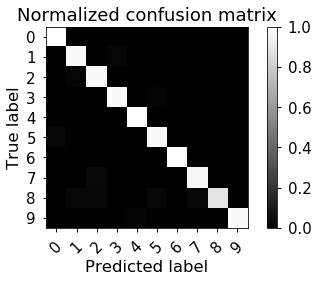

In [16]:
from sklearn.metrics import confusion_matrix
from sklearn import metrics
# Get confusion matrix
cm = confusion_matrix(Y_test_real, Y_pred_real)

#Normalize it
cm_norm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

# Plot it
plt.imshow(cm_norm, cmap = 'gray')
plt.title('Normalized confusion matrix')
plt.colorbar()
tick_marks = np.arange(n_classes)
plt.xticks(tick_marks, np.arange(n_classes), rotation=45)
plt.yticks(tick_marks, np.arange(n_classes))



plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

Let's print a summary of our model

In [17]:
# Visualizating filters
# https://blog.keras.io/how-convolutional-neural-networks-see-the-world.html
from keras import backend as K
K.set_learning_phase(1)
import tensorflow as tf


layer_dict = dict([(layer.name, layer) for layer in model.layers])
#print('Layer dict', layer_dict)
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 24, 24, 32)        832       
_________________________________________________________________
activation_1 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 64)          51264     
_________________________________________________________________
activation_2 (Activation)    (None, 8, 8, 64)          0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 4, 4, 64)          0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 4, 4, 64)          0         
__________

### What exactly does a CNN learn?
Now we will visualize the filters learned by the second convolutional network in our model, in order to see what type of features it is that the neural net is learning. We can extract the model filters easily. First we create a function that turns a tensor (the filters), into an image.

In [18]:
# util function to convert a tensor into a valid image
def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    #x = x.transpose((1, 2, 0))
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [24]:
layer_output = layer_dict['conv2d_2'].output

In [25]:
print (layer_output)

Tensor("conv2d_2/BiasAdd:0", shape=(?, 8, 8, 64), dtype=float32)


Next, we extract each of the filters of the second CNN and plot them:

In [21]:
def vis_img_in_filter(img = np.array(X_train[1]).reshape((1, 28, 28, 1)).astype(np.float64), 
                      layer_name = 'conv2d_2'):
    layer_output = layer_dict[layer_name].output
    img_ascs = list()
    for filter_index in range(layer_output.shape[3]):
        # build a loss function that maximizes the activation
        # of the nth filter of the layer considered
        loss = K.mean(layer_output[:, :, :, filter_index])

        # compute the gradient of the input picture wrt this loss
        grads = K.gradients(loss, model.input)[0]

        # normalization trick: we normalize the gradient
        grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

        # this function returns the loss and grads given the input picture
        iterate = K.function([model.input], [loss, grads])

        # step size for gradient ascent
        step = 5.

        img_asc = np.array(img)
        # run gradient ascent for 20 steps
        for i in range(20):
            loss_value, grads_value = iterate([img_asc])
            img_asc += grads_value * step

        img_asc = img_asc[0]
        img_ascs.append(deprocess_image(img_asc).reshape((28, 28)))
        
    if layer_output.shape[3] >= 35:
        plot_x, plot_y = 6, 6
    elif layer_output.shape[3] >= 23:
        plot_x, plot_y = 4, 6
    elif layer_output.shape[3] >= 11:
        plot_x, plot_y = 2, 6
    else:
        plot_x, plot_y = 1, 2
    fig, ax = plt.subplots(plot_x, plot_y, figsize = (12, 12))
    ax[0, 0].imshow(img.reshape((28, 28)), cmap = 'gray')
    ax[0, 0].set_title('Input image')
    fig.suptitle('Input image and %s filters' % (layer_name,))
    fig.tight_layout(pad = 0.3, rect = [0, 0, 0.9, 0.9])
    for (x, y) in [(i, j) for i in range(plot_x) for j in range(plot_y)]:
        if x == 0 and y == 0:
            continue
        ax[x, y].imshow(img_ascs[x * plot_y + y - 1], cmap = 'gray')
        ax[x, y].set_title('filter %d' % (x * plot_y + y - 1))

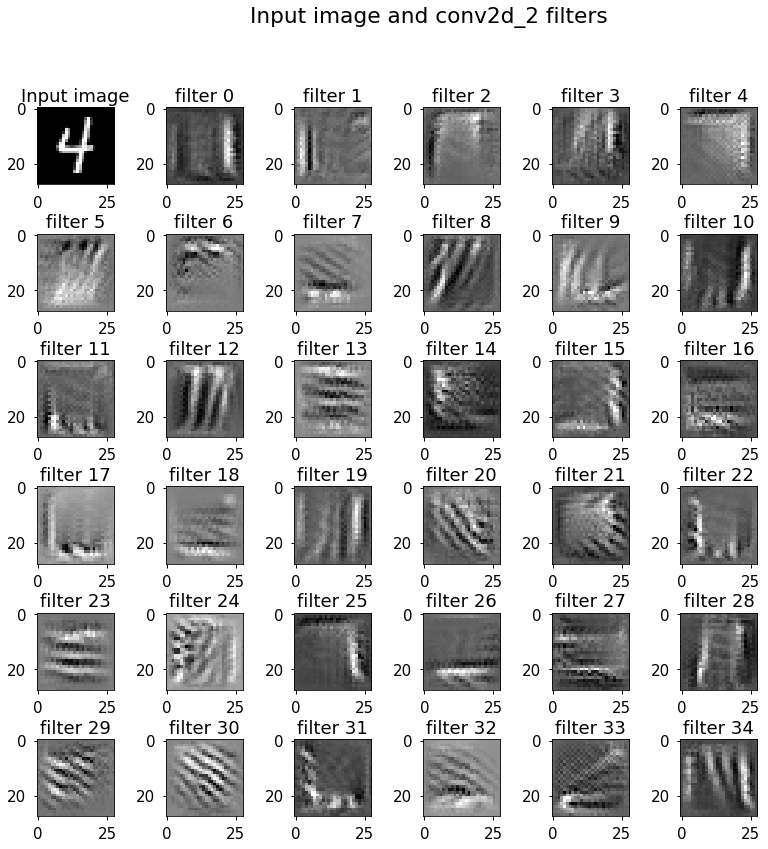

In [22]:
vis_img_in_filter()

### Exercise
Play with the CNN! See how the different hyperparameters affect your accuracy.